<a href="https://colab.research.google.com/github/ArshanBhanage/Clustering/blob/main/Audio_Clustering_Using_ImageBind_Audio_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q git+https://github.com/facebookresearch/ImageBind.git
!pip install -q torchaudio

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchaudio
from torchaudio.datasets import SPEECHCOMMANDS

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA

from imagebind.models import imagebind_model
from imagebind.models.imagebind_model import ModalityType
from imagebind.data import load_and_transform_audio_data


  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 65.0 MB/s eta 0:00:00


In [3]:
!pip install -q torchcodec # Install missing dependency

import os
from torchaudio.datasets import SPEECHCOMMANDS

root = "./speechcommands_data"

# 🔧 Make sure the directory exists
os.makedirs(root, exist_ok=True)

train_ds = SPEECHCOMMANDS(
    root=root,
    download=True,
    subset="training"  # "training" | "validation" | "testing" | None
)

print("Number of training samples:", len(train_ds))

waveform, sample_rate, label, speaker_id, utt_num = train_ds[0]
print("Example label:", label)
print("Waveform shape:", waveform.shape, "Sample rate:", sample_rate)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.2 MB/s eta 0:00:00
Number of training samples: 84843
Example label: backward
Waveform shape: torch.Size([1, 16000]) Sample rate: 16000


In [27]:
# How many samples to use for clustering
# Increased N to 5000 to ensure more diverse labels for clustering metrics.
N = 5000

audio_paths = []
label_strings = []

# The root where SPEECHCOMMANDS stores its data (e.g., './speechcommands_data')
dataset_base_root = root # 'root' is defined in cell R-SmkLlBYH0-

for i in range(N):
    # get_metadata returns a path relative to os.path.join(dataset_base_root, 'SpeechCommands')
    rel_audio_path, sr, label, speaker_id, utt_num = train_ds.get_metadata(i)

    # Construct the full absolute path
    # The actual audio files are typically in dataset_base_root/SpeechCommands/.
    # The rel_audio_path often starts with 'speech_commands_v0.02/...' due to extraction.
    full_audio_file_path = os.path.join(dataset_base_root, 'SpeechCommands', rel_audio_path)

    audio_paths.append(full_audio_file_path)
    label_strings.append(label)

audio_paths = np.array(audio_paths)
label_strings = np.array(label_strings)

print("Number of audio files:", len(audio_paths))
print("First 5 paths:", audio_paths[:5])
print("First 5 labels:", label_strings[:5])

Number of audio files: 5000
First 5 paths: ['./speechcommands_data/SpeechCommands/speech_commands_v0.02/backward/0165e0e8_nohash_0.wav'
 './speechcommands_data/SpeechCommands/speech_commands_v0.02/backward/017c4098_nohash_0.wav'
 './speechcommands_data/SpeechCommands/speech_commands_v0.02/backward/017c4098_nohash_1.wav'
 './speechcommands_data/SpeechCommands/speech_commands_v0.02/backward/017c4098_nohash_2.wav'
 './speechcommands_data/SpeechCommands/speech_commands_v0.02/backward/017c4098_nohash_3.wav']
First 5 labels: ['backward' 'backward' 'backward' 'backward' 'backward']


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = imagebind_model.imagebind_huge(pretrained=True)
model.eval()
model.to(device)


Using device: cuda


ImageBindModel(
  (modality_preprocessors): ModuleDict(
    (vision): RGBDTPreprocessor(
      (cls_token): tensor((1, 1, 1280), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Sequential(
          (0): PadIm2Video()
          (1): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
        )
      )
      (pos_embedding_helper): SpatioTemporalPosEmbeddingHelper(
        (pos_embed): tensor((1, 257, 1280), requires_grad=True)
        
      )
    )
    (text): TextPreprocessor(
      (pos_embed): tensor((1, 77, 1024), requires_grad=True)
      (mask): tensor((77, 77), requires_grad=False)
      
      (token_embedding): Embedding(49408, 1024)
    )
    (audio): AudioPreprocessor(
      (cls_token): tensor((1, 1, 768), requires_grad=True)
      
      (rgbt_stem): PatchEmbedGeneric(
        (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10), bias=False)
        (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=

In [ ]:
# ImageBind has a helper to load & transform audio inputs
audio_embeddings_list = []

# Process in batches of file paths
batch_size = 32
for i in range(0, len(audio_paths), batch_size):
    batch_paths = audio_paths[i:i+batch_size]

    with torch.no_grad():
        inputs = {
            ModalityType.AUDIO: load_and_transform_audio_data(batch_paths, device)
        }
        outputs = model(inputs)
        emb = outputs[ModalityType.AUDIO]  # (batch_size, d)
        audio_embeddings_list.append(emb.cpu())

audio_embeddings = torch.cat(audio_embeddings_list, dim=0).numpy()
print("Audio embeddings shape:", audio_embeddings.shape)

In [30]:
unique_label_indices = np.unique(label_strings)
k = len(unique_label_indices)
print("Number of unique true labels in subset:", k)

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(audio_embeddings)

print("Cluster labels (first 20):", cluster_labels[:20])
print("Unique clusters:", np.unique(cluster_labels))

Number of unique true labels in subset: 4
Cluster labels (first 20): [2 2 3 3 3 2 3 3 3 3 3 3 3 2 2 0 0 0 3 3]
Unique clusters: [0 1 2 3]


In [31]:
# Map label_strings to numerical labels for metrics
labels_map = {label: idx for idx, label in enumerate(unique_label_indices)}
labels = np.array([labels_map[s] for s in label_strings])
label_names = list(unique_label_indices)

# Silhouette in embedding space (unsupervised)
sil = silhouette_score(audio_embeddings, cluster_labels)
print("Silhouette score (ImageBind audio embedding space):", sil)

# Adjusted Rand Index vs true labels (for reference)
ari = adjusted_rand_score(labels, cluster_labels)
print("Adjusted Rand Index (vs true labels):", ari)

Silhouette score (ImageBind audio embedding space): 0.075181566
Adjusted Rand Index (vs true labels): 0.04698508568348327


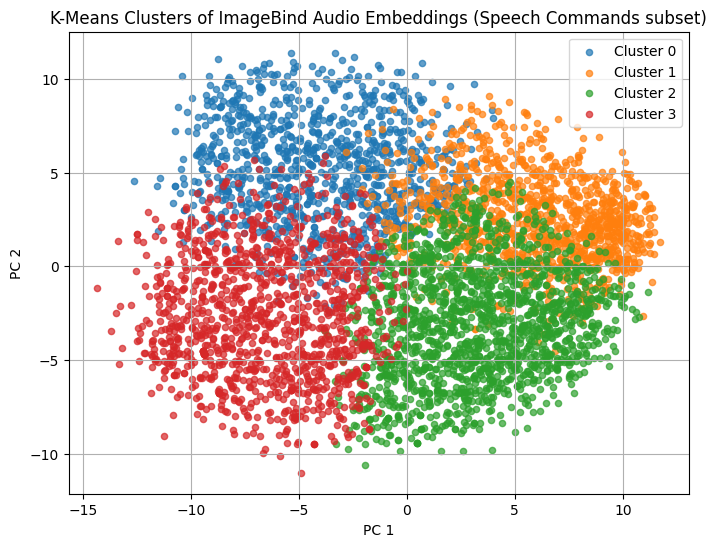

In [32]:
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(audio_embeddings)

plt.figure(figsize=(8, 6))
for c in np.unique(cluster_labels):
    mask = cluster_labels == c
    plt.scatter(
        emb_2d[mask, 0],
        emb_2d[mask, 1],
        alpha=0.7,
        s=20,
        label=f"Cluster {c}"
    )

plt.title("K-Means Clusters of ImageBind Audio Embeddings (Speech Commands subset)")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from collections import Counter

# Ensure labels and label_names are defined for this cell
labels_map = {label: idx for idx, label in enumerate(unique_label_indices)}
labels = np.array([labels_map[s] for s in label_strings])
label_names = list(unique_label_indices)

print("Cluster → true label (command) distribution:")
for c in np.unique(cluster_labels):
    idxs = np.where(cluster_labels == c)[0]
    cluster_true_labels = labels[idxs]
    counts = Counter(cluster_true_labels)

    print(f"\nCluster {c} (size={len(idxs)}):")
    for label_idx, count in counts.items():
        print(f"  {label_names[label_idx]}: {count}")

Cluster → true label (command) distribution:

Cluster 0 (size=1028):
  backward: 146
  bed: 408
  bird: 372
  cat: 102

Cluster 1 (size=1131):
  backward: 80
  bed: 446
  bird: 516
  cat: 89

Cluster 2 (size=1629):
  backward: 500
  bed: 476
  bird: 565
  cat: 88

Cluster 3 (size=1212):
  backward: 620
  bed: 264
  bird: 244
  cat: 84


## Audio Clustering with ImageBind Embeddings (Speech Commands)

- **Dataset:** `speech_commands` (HuggingFace) – short audio clips of spoken words.
- **Embeddings:** ImageBind audio encoder (`imagebind_huge`) used to convert each audio clip into a high-dimensional embedding.
- **Pipeline:**
  1. Load a subset of the speech commands dataset.
  2. Save each clip as a `.wav` file.
  3. Use ImageBind's audio preprocessing and model to obtain embeddings.
  4. Apply **K-Means** clustering on audio embeddings, with `k` equal to the number of unique labels in the subset.
  5. Evaluate clustering quality with:
     - **Silhouette score** (unsupervised).
     - **Adjusted Rand Index (ARI)** vs true spoken-word labels (for reference).
  6. Analyze cluster → label distributions to see which speech commands end up grouped together.
- **Observation:** Audio clips that sound similar (e.g., same or related spoken words) tend to be close in the ImageBind embedding space, enabling simple clustering algorithms like K-Means to separate them into meaningful groups.
